# Part I - (Dataset Exploration Title)
## by (your name here)

## Introduction
> We're going to be using a dataset from the [Bureau of Transportation Statistics (BTS)](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr) that measure the lateness of the flights and the reason for them. We will also load two auxiliary datasets [(Gathered by Harvard Dataverse)](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009) to identify the aiports and Airlines.

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import datetime, warnings, scipy 
import pandas as pd
import matplotlib as mpl
import folium
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import requests
%matplotlib inline

> Load the datasets and start the wrangling of data


In [2]:
# Load our dataset with pandas and explore it. 
df = pd.read_csv('flight_delays.csv')

# Load the Airport and airlines database.

df_airports = pd.read_csv('airports.csv')
df_carriers = pd.read_csv('carriers.csv')

### Main Dataframe 

In [3]:
df.head()

,YEAR,QUARTER,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY_NEW,...,ARR_DELAY_GROUP,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2022,1,1,1/3/2022 12:00:00 AM,9E,9E,ABE,ATL,NaN,NaN,...,NaN,1.0,0.0,NaN,692.0,NaN,NaN,NaN,NaN,NaN
1,2022,1,1,1/3/2022 12:00:00 AM,9E,9E,ABE,ATL,NaN,NaN,...,NaN,1.0,0.0,NaN,692.0,NaN,NaN,NaN,NaN,NaN
2,2022,1,1,1/3/2022 12:00:00 AM,9E,9E,ABE,DTW,NaN,NaN,...,NaN,1.0,0.0,NaN,425.0,NaN,NaN,NaN,NaN,NaN
3,2022,1,1,1/3/2022 12:00:00 AM,9E,9E,ABE,DTW,628.0,53.0,...,2.0,0.0,0.0,73.0,425.0,35.0,0.0,0.0,0.0,0.0
4,2022,1,1,1/3/2022 12:00:00 AM,9E,9E,ABY,ATL,709.0,0.0,...,-1.0,0.0,0.0,43.0,145.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# we are going to drop the rows that have no delay, or arrived earlier since our interest is the flights that arrived late.
df.drop(df[df.ARR_DELAY_GROUP <= 0].index, axis = 0, inplace = True)

# We're also going to eliminate cancelled or diverted flights
df.drop(df[df['CANCELLED'] == 1.0].index, axis = 0, inplace=True)
df.drop(df[df['DIVERTED'] == 1.0].index, axis = 0, inplace=True)



In [5]:
# Check that we have eliminated the rows
df.ARR_DELAY_GROUP.value_counts()

1.0     33234
2.0     18238
3.0     11695
4.0      7980
12.0     5888
5.0      5595
6.0      4261
7.0      3162
8.0      2419
9.0      1893
10.0     1551
11.0     1136
Name: ARR_DELAY_GROUP, dtype: int64

We're going to eliminate the outliers. We are going to make a business decision and set the upper limit on 500 min. Since flights with more than 8h delay are not considered "normal".

In [6]:
# We are gonna eliminate the outliers 
df.drop(df[df.DEP_DELAY_NEW > 500].index, axis = 0, inplace = True)

### Airports Dataframe

In [7]:
df_airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [8]:
df_airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iata     3376 non-null   object 
 1   airport  3376 non-null   object 
 2   city     3364 non-null   object 
 3   state    3364 non-null   object 
 4   country  3376 non-null   object 
 5   lat      3376 non-null   float64
 6   long     3376 non-null   float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


### Airlines Dataframe

In [9]:
df_carriers.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [10]:
df_carriers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         1490 non-null   object
 1   Description  1491 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


### What is the structure of your dataset?

> We have a main dataframe with the information about delays and two auxiliary dataframes that we will use to add information to our main dataframe, such as Aiport and Carrier names and locations for further analysis.
    The airlines and carriers dataframes contain the IATA codes to identify the airports and carriers of each flight in the main dataframe.

### What is/are the main feature(s) of interest in your dataset?

> The main features of interest is the delay and sub_groups of delays that the dataset offers. For example, we can check why the delay happended: Security, carrier, weather, etc.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I will like to find relationships between carriers, their hub airports and specific days / moments of the week to visualize the specific features that make a flight prone to delays.

#### How is the Distribution of minutes late for flights?

(0.0, 300.0)

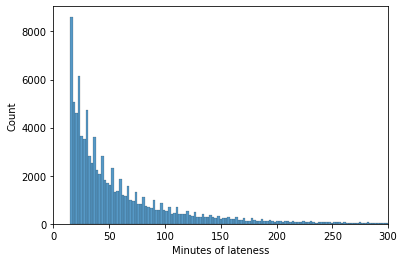

In [11]:
# Create our fig and ax objects
fig, ax = plt.subplots()
# Create our plot and set limits
sb.histplot(data = df, x = 'ARR_DELAY_NEW');
ax.set_xlabel('Minutes of lateness');
ax.set_xlim(0,300)

We see that this distribution is extremely right skewed and unimodel. We can also see that it could use a logarithmic transformation. We'll do that in the following viz. We can also observe that lateness is mostly being recorded in "round" numbers since there are spikes in mostly all multiples of 10. 

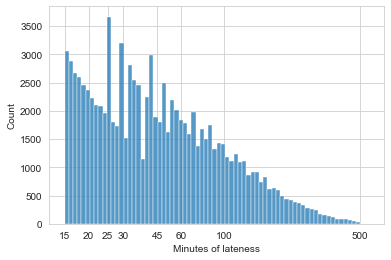

In [32]:
# Create our plot
fig, ax = plt.subplots()
# Set Logarithmic scale
sb.histplot(data = df, x = 'ARR_DELAY_NEW', log_scale= True);
# Adapt ticks for new scale
xticks = [15, 20, 25, 30, 45, 60,100,500]
plt.xticks(xticks, xticks)
ax.set_xlabel('Minutes of lateness');

We can see that the vast majority of delayed flights have between 15-100 mins of delay. We can observe a more or less bi-modal distribution, with spikes in 15 and around 45-60 mins. 

#### What is the main reason for lateness in flights?
Let's plot the most repeated reson for the lateness of flights

In [13]:
data = df[['LATE_AIRCRAFT_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'WEATHER_DELAY', 'CARRIER_DELAY']].mean()
mean = pd.DataFrame(data, columns= ['mean_delay'])

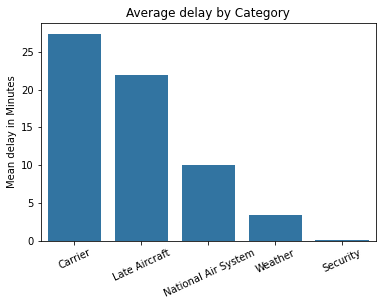

In [14]:
fig, ax = plt.subplots()
labels = ['Carrier', 'Late Aircraft', ' National Air System', 'Weather', 'Security']
sb.barplot(data = mean, x = data.index,  y = 'mean_delay', color = sb.color_palette()[0],
                        order= ['CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'NAS_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY']);
plt.xticks(rotation = 25);
ax.set_xticklabels(labels);
plt.title('Average delay by Category');
plt.ylabel('Mean delay in Minutes');

We can see that the Carriers are at fault (in average) of the bigger delays. It's worth pointing out that delays are rarely a one man fault, a National Air System delay can be the starter of the problem, then the aircraft will arrive later than expected, which will trigger a delay due to lack of personnel etc.

#### How are carriers performing in terms of delays?

I want to check how the airlines perform in terms of delays caused by their own. In the Bi-variate plots, we'll check how much the total delay is due to delays caused by the airlines themselves.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96335 entries, 3 to 537901
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 96335 non-null  int64  
 1   QUARTER              96335 non-null  int64  
 2   DAY_OF_WEEK          96335 non-null  int64  
 3   FL_DATE              96335 non-null  object 
 4   OP_UNIQUE_CARRIER    96335 non-null  object 
 5   OP_CARRIER           96335 non-null  object 
 6   ORIGIN               96335 non-null  object 
 7   DEST                 96335 non-null  object 
 8   DEP_TIME             96335 non-null  float64
 9   DEP_DELAY_NEW        96335 non-null  float64
 10  DEP_DELAY_GROUP      96335 non-null  float64
 11  ARR_TIME             96335 non-null  float64
 12  ARR_DELAY_NEW        96335 non-null  float64
 13  ARR_DELAY_GROUP      96335 non-null  float64
 14  CANCELLED            96335 non-null  float64
 15  DIVERTED             96335 non-null

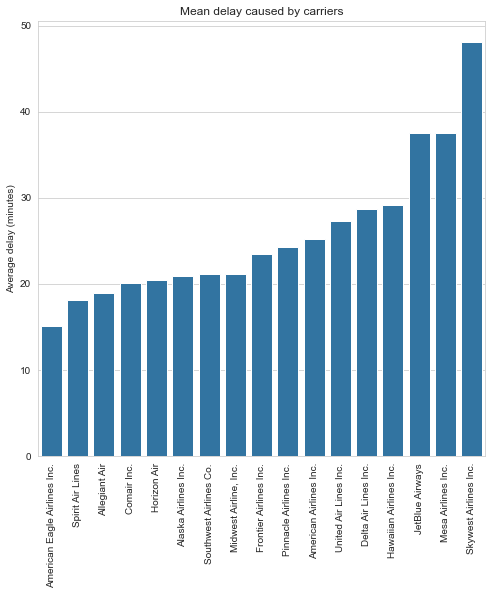

In [16]:
# Extract and calculate the data
data = df.merge(df_carriers, left_on= 'OP_CARRIER', right_on= 'Code', how='left')
data_group = data.groupby(['Description']).mean()
order = data_group['CARRIER_DELAY'].sort_values()

# Plot the barplot and order it
plt.figure(figsize = (8, 8))
sb.set_style("whitegrid")
ax = sb.barplot(data = data_group, x = data_group.index, y = 'CARRIER_DELAY', color = sb.color_palette()[0], order = order.index);
plt.xticks(rotation = 90);
plt.title('Mean delay caused by carriers');
plt.ylabel('Average delay (minutes)');
ax.set(xlabel=None);




The graph shows that there is an abismal difference in average between carriers. For example, a Skywest frequent flier can expect almost 3 times more delay than an American Eagle one. We will check if this ranking holds when we take into account the whole delay. 

Also, it's woth pointing out that the best and two worst performers are actually regional carriers. We'll dig into this issue later. 

#### Does the day of the week affect on delays?

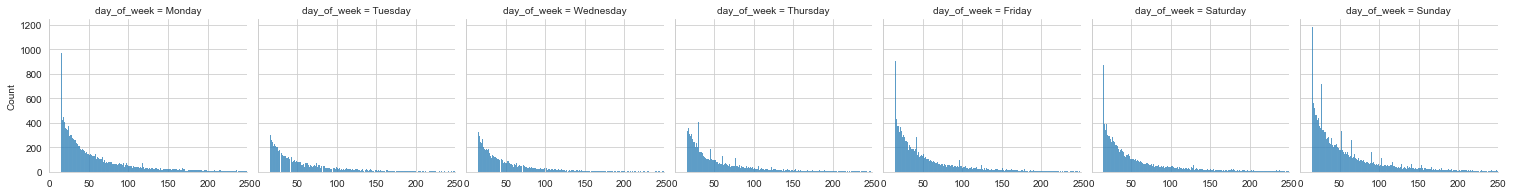

In [17]:
# We set up our airlines as classes for the visualization.
days = {1: "Monday",
        2: "Tuesday",
        3: "Wednesday",
        4: "Thursday",
        5: "Friday",
        6: "Saturday",
        7: "Sunday"}
data['day_of_week'] = data["DAY_OF_WEEK"].map(days)

days_class = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dclass = pd.api.types.CategoricalDtype(ordered=True, categories= days_class)
data['day_of_week'] = data['day_of_week'].astype(dclass)
# Faceted grid
g = sb.FacetGrid(data = data, col = 'day_of_week', sharey=True);
g.map(sb.histplot, "ARR_DELAY_NEW", bins = 500);
g.set(xlim = (0,250));
g.set(xlabel = None);

We can see, that in fact, it does have an effect on the on-time performance of flights. We can see that Saturday and Monday are by far the most affected days. This could be expected, since they are also the days with the most traffic. 

The graphic also show, that, while on monday and Saturday the delays increase, the distribution is always the same. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

 We needed to:
 * Eliminate on-time and early arriving flighs since they're not of our interest. 
 * Map values of companies and days so that we can have useful information. 
 * Transformed airlines and day of the week variables into categories.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> There is not an unsual distribution per se, in any of the data. We applied a logarithmic transformation on the lateness variable to be able to visualize it better. We checked that it is actually bi-modal (one spike in 15 mins and another one between 45-60 mins). 

## Bivariate Exploration

#### Are there Specific Routes that have more delays?

In [18]:
# We're just interested in the names of the airports
airport_merge = df_airports.drop(['city', 'state', 'country', 'lat', 'long'], axis = 1)
# Join Airports and main dataframe
new_df = data.merge(airport_merge, left_on= 'ORIGIN', right_on = 'iata', how = 'left')
new_df.rename({'airport': 'origin_airport'}, axis = 1, inplace=True)
new_df = new_df.merge(airport_merge, left_on= 'DEST' , right_on = 'iata', how = 'left')
new_df.rename({'airport': 'dest_airport'}, axis = 1, inplace = True)

# Create a field for routes
new_df['route_code'] = new_df['iata_x'] + ' - ' + new_df['iata_y']
new_df['route_expand'] = new_df['origin_airport'] + ' - ' + new_df['dest_airport']

# Group Data by Route
route_data = new_df.groupby('route_code').mean()



There are 5650 routes on this dataset, as this would be impossible to visualize, let's check the 25 first routes with more average delay and see their data.

/var/folders/yv/tcwpp6310b54wsdrfcqhjbyh0000gn/T/ipykernel_36307/3207836895.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_df['route_code'] = route_df['route_code'].astype(route_cat);


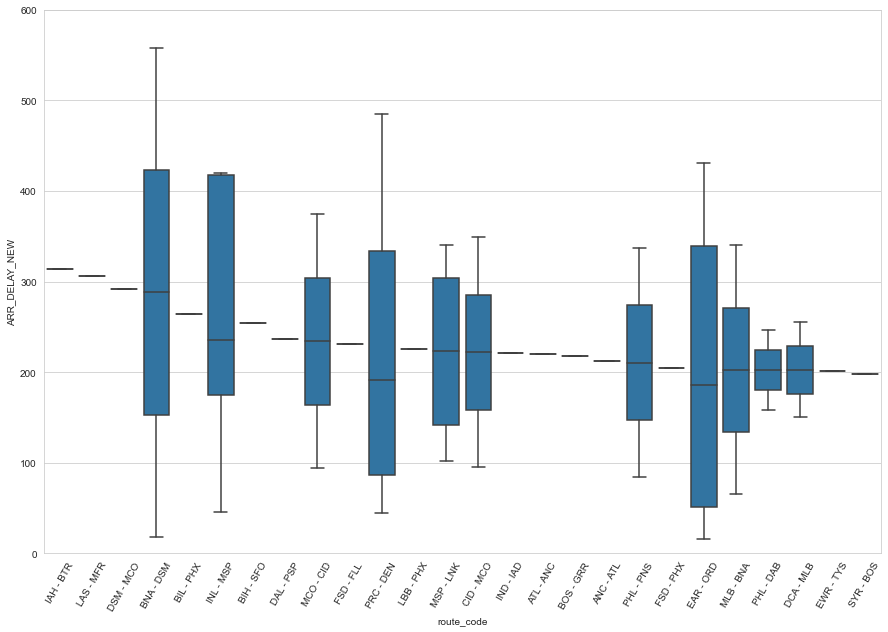

In [19]:
route_data.sort_values('ARR_DELAY_NEW', inplace= True, ascending = False);

# Now we select the 25 first values
reduced_data = route_data.iloc[:26];
#Extract the index (routes)
routes = [route for route in reduced_data.index];
# Filter only the data for this routes
route_df = new_df[new_df['route_code'].isin(routes)];

# Convert our routes into a category
route_cat = pd.api.types.CategoricalDtype(ordered=True, categories=routes);
route_df['route_code'] = route_df['route_code'].astype(route_cat);


plt.figure(figsize = (15,10));
sb.boxplot(data = route_df, x = 'route_code', y = 'ARR_DELAY_NEW', color = sb.color_palette()[0]);
plt.xticks(rotation = 60);
plt.ylim(0,600);


We can See a high Variability in between routes. We can also see, that most routes have flights that could be considered outliers. 

For example, we can see, that the mean delay in the route DSM - MCO (Des Moines International - Orlando International) is expected to be almos 300 minutes (5 hours late!).

#### Are longer Routes more prone to delays?

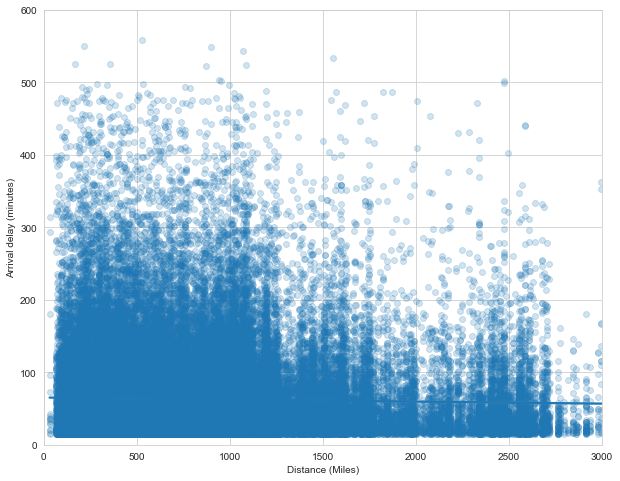

In [20]:
plt.figure(figsize = (10,8))
#plt.scatter(data = new_df, x = 'DISTANCE', y = 'ARR_DELAY_NEW')
sb.regplot(data = new_df, x = 'DISTANCE', y = 'ARR_DELAY_NEW', scatter_kws={'alpha' : 1/5});
plt.ylim(0,600);
plt.xlim(0,3000);
plt.xlabel('Distance (Miles)');
plt.ylabel('Arrival delay (minutes)');

The plot has too many datapoints to show, but we can see that, there is a descent in the delay when distance grows. It's not a clear relationship, but we can say that, with distance, delays are reduced. 

This makes sense in an operational way. Planes that serve short / medium haul routes fly more than 1 time a day, having more probabilities of experiencing events that compund into delays.

#### Are Departure and Arrival delays perfectly correlated?

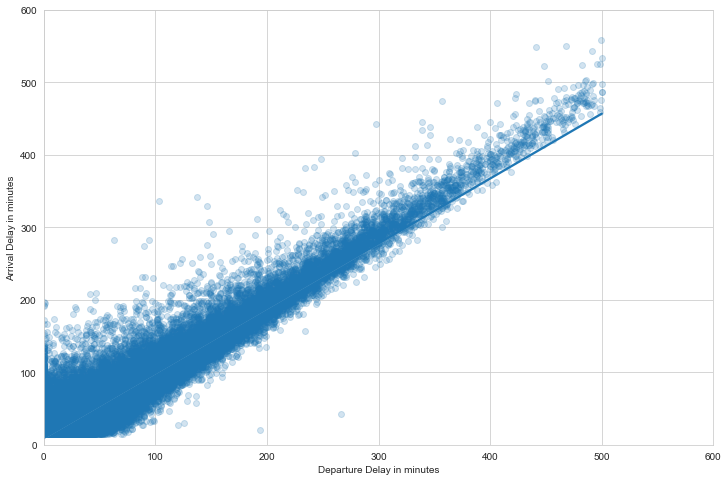

In [21]:
plt.figure(figsize=(12,8))

sb.regplot(data= new_df, x = 'DEP_DELAY_NEW', y = 'ARR_DELAY_NEW', scatter_kws={'alpha' : 1/5});
plt.xlim(0,600);
plt.ylim(0, 600);

plt.xlabel('Departure Delay in minutes');
plt.ylabel('Arrival Delay in minutes');

Seems like, arrival delay is consistently worse than departure delay, and the effect is worse when departure delay is bigger.

#### Do different airlines have a different distribution of lateness?

In [22]:
# Create airline as a category.
airlines = [airline for airline in new_df['Description'].unique()]
air_cat = pd.api.types.CategoricalDtype(ordered = False, categories= airlines)
new_df['Description'] = new_df['Description'].astype(air_cat)
new_df.rename({'Description': 'Airline'}, axis=1, inplace=True)

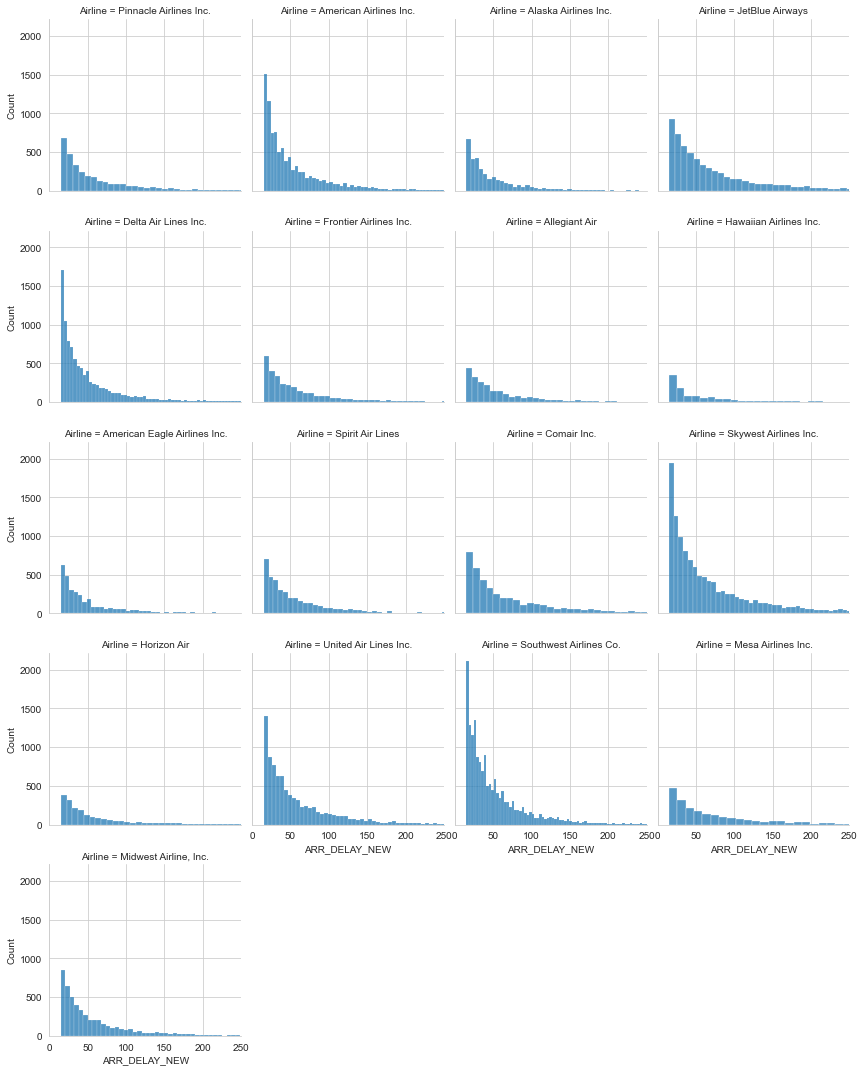

In [23]:
plot = sb.FacetGrid(data = new_df, col = 'Airline', col_wrap=4);
plot.map(sb.histplot, 'ARR_DELAY_NEW')
plot.set(xlim = (0,250));

We can see that the worst Performers are:
* SkyWest Airlines
* Delta 
* Southwest Airlines
* American Airlines

Let's make another plot to better compare the densities:

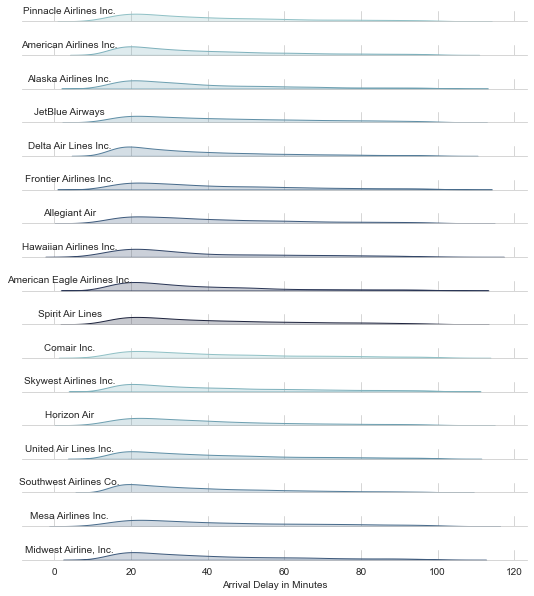

In [24]:
# We reduce the data to bettter visualize
sub_df = new_df.query("ARR_DELAY_NEW <= 100")

# Configure our plot
pal = sb.cubehelix_palette(10, rot=-.25, light=.7);
g = sb.FacetGrid(sub_df, row="Airline", hue="Airline", aspect=15, height=.5, palette=pal);
g.map(sb.kdeplot, 'ARR_DELAY_NEW', shade = True);

g.set(yticks=[]);
g.set(ylabel= None);
g.despine(left=True);
# Set transparency to 100%
g.map(lambda **kwargs: plt.gca().patch.set_alpha(0));

# We took this function from the Udacity Course.
def label_text(x, **kwargs):
    plt.text(4, 0.02, x.iloc[0], ha = 'center', va = 'bottom')
g.map(label_text, 'Airline');
g.set_xlabels('Arrival Delay in Minutes');
g.set_titles('');


We can see that most airlines have a similar behaviour, with the higher density around 20 minutes of delay

#### Do Delays depend on the origin airport?

We're going to inspect this with just one airline for simplicity purposes. We'll choose Delta Airlines and we'll choose the 25 airports with more traffic for Delta.

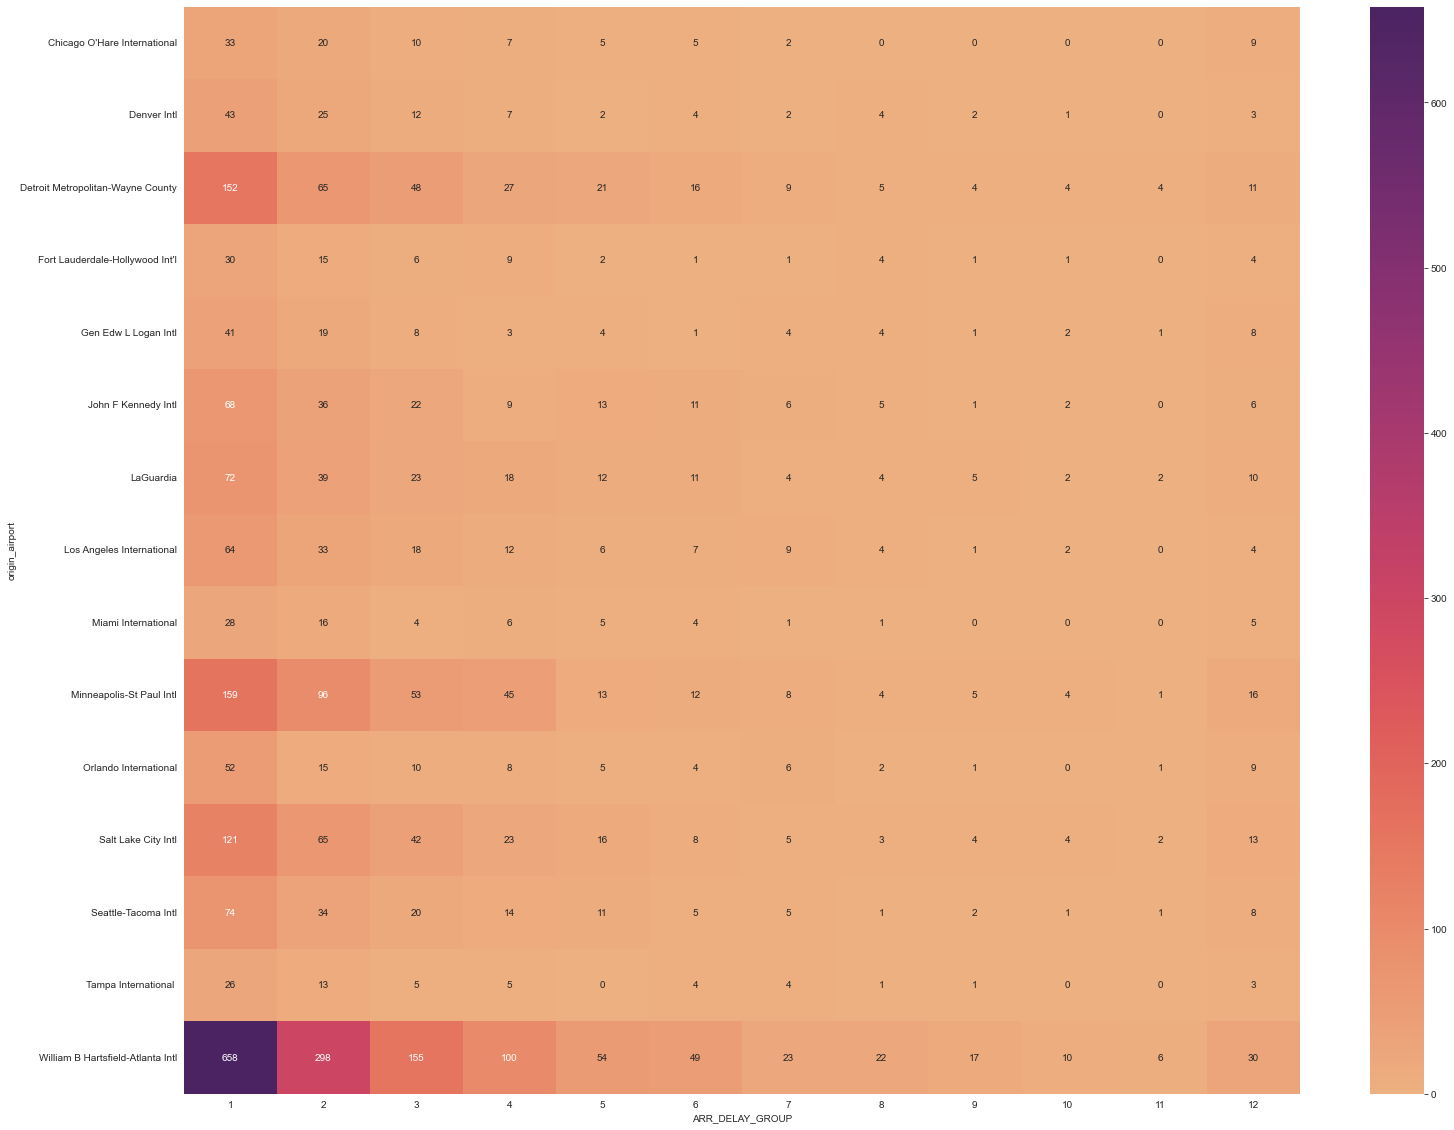

In [30]:
# Select Data for Delta Airlines
new_df.ARR_DELAY_GROUP = new_df.ARR_DELAY_GROUP.fillna(1.0)
delta_df = new_df.query("Airline == 'Delta Air Lines Inc.'")
delta_df = delta_df.astype({'ARR_DELAY_GROUP' : int})

# Select 25 airports with more traffic
airports = delta_df.groupby('origin_airport').size().sort_values(ascending = False).iloc[:15].index
delta_df = delta_df[delta_df['origin_airport'].isin(airports)]

df_heatmap = delta_df.groupby(['origin_airport', 'ARR_DELAY_GROUP']).size()
df_heatmap = df_heatmap.reset_index(name = 'count')
df_heatmap = df_heatmap.pivot(index = 'origin_airport', columns = 'ARR_DELAY_GROUP', values = 'count') / len(df_heatmap) * 100;
df_heatmap = df_heatmap.fillna(0)
df_heatmap = df_heatmap.astype(int)

plt.figure(figsize = (25, 20))
sb.heatmap(df_heatmap, annot = True, fmt = 'd', cmap = sb.color_palette("flare", as_cmap=True));


We can see that there are some airports with higher levels of delays than others. Atlanta airport is the worst performer for Delta Airlines. It makes sense, since Atlanta is Delta's main hub and the airport with the most level of traffic. 

We can also see, how bigger airports perform consistenly worse. 

#### Which Airlines have a worst punctuality ratio?

We're going to check which airlines perform worst. 

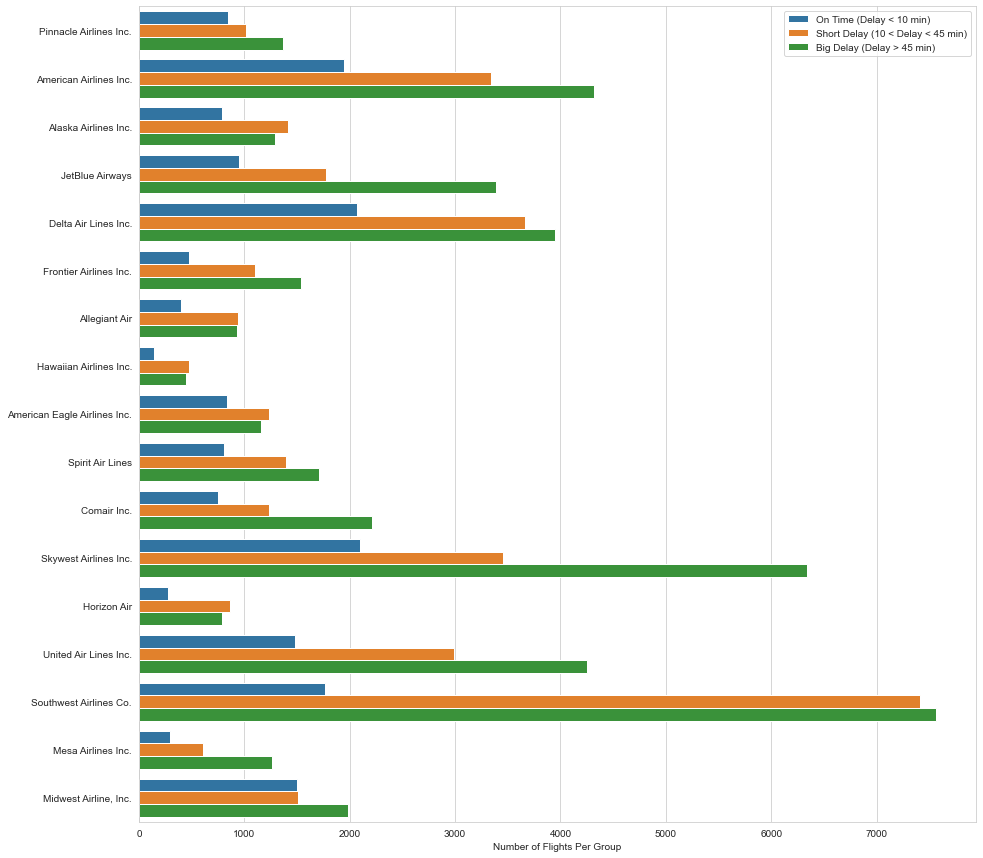

In [26]:
# We create New groups to measure delay. 
# 0 -> Punctual flights (delay < 10 minutes)
# 1 -> Little Delay (10 - 45 minutes)
# 2 -> Big delay (> 45 minutes)
delay = lambda x:((0,1)[x > 10], 2)[x > 45]
new_df['delay_group'] = new_df['DEP_DELAY_NEW'].apply(delay)

# Countplot 
fig = plt.figure(1, figsize = (15,15))
ax = sb.countplot(data = new_df, y = 'Airline', hue = 'delay_group')
ax.yaxis.label.set_visible(False)

# Set up a legend and show the plot
legend = plt.legend()
legend.get_texts()[0].set_text('On Time (Delay < 10 min)')
legend.get_texts()[1].set_text('Short Delay (10 < Delay < 45 min)')
legend.get_texts()[2].set_text('Big Delay (Delay > 45 min)')
plt.xlabel('Number of Flights Per Group')
plt.show()

This graph shows us, that while smaller airlines tend to have a more balanced equilibrium between groups (for example American Eagle and Midwest Airlines have an almost equal balance), bigger airlines such as Delta, Skywest, Southwest have a distribution more skewed to bigger delays. 

From the last two graphs we can see, that the bigger the operative and concentration of operations, the bigger the delays.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> It was interesting to see how the main variables were correlated. We could see how the airline that you use, as well as the airport are some of the main variable that could predict the lateness of your flight. We could also see how distance is somewhat negatively correlated with delays. This makes sense, as longer flights are usually performed once in a day, while the same plane on a shorte flights makes 3 or 4 legs every day, giving more chance for delays.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> I expected to see that smaller airlines perfomed worst (due to lack of personnel, issues with smaleer airports etc.), but, in the end, is clear, that a bigger operative, means bigger delays.

## Multivariate Exploration

#### Is there a relationship between short, medium and long haul flights and lateness?

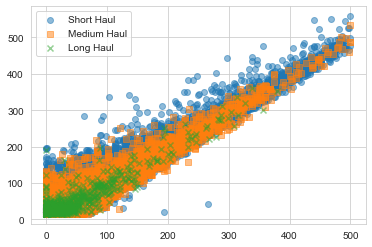

In [27]:
# We create the groups
air_time = lambda x:(('Short Haul', 'Medium Haul')[x > 180], 'Long Haul')[ x > 360]
new_df['air_time_group'] = new_df['AIR_TIME'].apply(air_time)

# Plot
markers = [['Short Haul', 'o'], ['Medium Haul', 's'], ['Long Haul', 'x']]

for cat, marker  in markers:
    df_cat = new_df[new_df['air_time_group'] == cat]
    plt.scatter(data = df_cat, x = 'DEP_DELAY_NEW', y = 'ARR_DELAY_NEW', marker = marker, alpha= 0.5);

plt.legend(['Short Haul', 'Medium Haul', 'Long Haul'])

We confirm what we said earlier. Flights on long haul tend to have shorter delays. Medium has a much wider distribution and then short haul are the most affected. 

#### Does the day of the week affect the performance of short, medium and long haul flights?

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


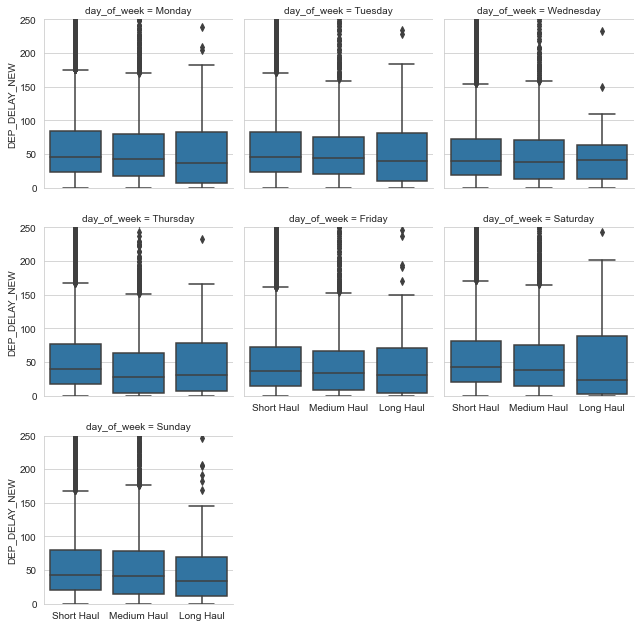

In [28]:
# Create categories of Month and short,medium, long haul
fly_type = ['Short Haul', 'Medium Haul', 'Long Haul']

type_cat = pd.api.types.CategoricalDtype(ordered=True, categories=fly_type)
new_df['air_time_group'] = new_df['air_time_group'].astype(type_cat)

# Plot 

g = sb.FacetGrid(data = new_df, col = 'day_of_week', col_wrap=3);
g.map(sb.boxplot, 'air_time_group', 'DEP_DELAY_NEW');
g.set(ylim = (0,250));
g.set(xlabel = None);


We can see that long haul flights have the greatest variability. Also, short haul flights seem to have the same distribution pretty much every day.

#### How does different delays correlate to the whole delay?

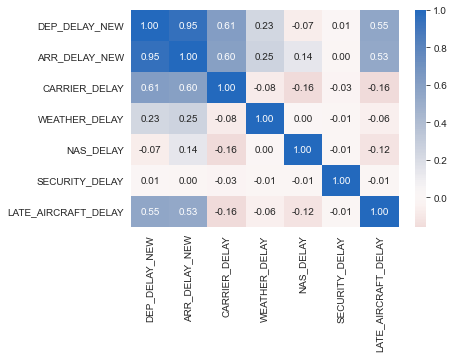

In [29]:
# select just the delays
df_corr = new_df[['DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

# Plot the heatmap of correlations
sb.heatmap(df_corr.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0);

In [31]:
# Save final dataframe with changes performed
new_df.to_csv('final_df.csv')

The correlation plot shows us that: 
* 95% of the arrival delays are caused by departure delays.
* The Carrier and late aircraft delays are the more correlated with departure delays.
* The National Air System delays are correlated with arrival delays, but not with departures.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> We looked at the relationship between different kinds of flights (which need different operatives), days of the week and the relationships between carriers and their lateness. 

### Were there any interesting or surprising interactions between features?

> It's interesting that the National Air system delays are only positively correlated with arrival delays, which could be interpreted as follows: Arrival procedures in airports are more stringent and complicated, hence, there's a higher chance of producing delays (because of circling or go-around manouvers waiting for clearance to land).

## Conclusions
> It was hard to work with data that is so spread out, for future explorations, we could divide the data by airline, week etc, to make it more granular and readable 

* We found that the main factor for delays was carrier induced delays. 
* Airlines that have a bigger volume of flights tend to have more delays.
* There's a negative correlation between distance flown and delays.
    * This can be explained due to Operating factors. As a plane flies more legs on one day, delays tend to accumulate.
* Following on the last point, we checked the difference between short, medium and long haul flights. We observed the same relationship.
* We also found that, the bigger the airline, the more skewed to bigger delays they are.
* 95% of the arrival delays are explained by departure delays, meaning that rarely a flight is delayed more on arrival than on departure.
* The other 5% is mainly explained by National Air System Delays, which can be due to saturation in arrivals, meteorology-led deviations from routes etc. 
